In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

Rules:
* (EN) both control questions true
* (EN) native speaker true
* interviewtime greater than 60
* min_year 1910, max_year 2005
* philosophy_education_level other than 'nan' or 1.0
* (PL) lastpage lesser than 3
* (EN) lastpage lesser than 5

In [3]:
import glob, os, re
import pandas as pd
import numpy as np
from tabulate import tabulate

from config import DATA_PATH, get_remove_categories
from translation import get_renaming_dict, get_boolean_dict, get_score_dict, get_education_dict

LANGUAGES = ['pl', 'en']
STORIES = ['Chemist', 'Truetemp', 'Coinflip']
INTERVIEW_TIME_THRESHOLD = 60.
YEAR_MIN = 1910
YEAR_MAX = 2005

def get_time_dict(columns, stories, language):
    times_regex = re.compile('groupTime.*')
    times = list(filter(times_regex.match, columns))
    times_to_drop = [] if language == 'pl' else [times[1], times[3]]
    times_to_translate = times if language == 'pl' else [times[0], times[2], times[4]]
    named_times = ['interviewee_info_time', '{}_time'.format(stories[0]), '{}_time'.format(stories[1])]
    time_translation = {column: translated for column, translated in zip(times_to_translate, named_times)}
    
    return time_translation, times_to_drop

def process(which_language):
    language = LANGUAGES[which_language]
    files = glob.glob(os.path.join(DATA_PATH, language, '**/*.csv'))
    
    dfs = dict()
    for file in files:
        # Read file
        df = pd.read_csv(file)
    
        # Remove completely empty columns and rows
        df = df.dropna(axis=1, how='all').dropna(axis=0, how='all')
    
        # Translate columns
        translation_dict = {**get_boolean_dict(language), **get_score_dict(language), **get_education_dict(language)}
        df = df.rename(columns=get_renaming_dict(language))
        
        # Identify stories
        stories = [column for column in df.columns if column in STORIES]
        interview = '{}-{}'.format(*stories)

        # Drop meaningless columns
        df = df.drop(columns=get_remove_categories(language), errors='ignore')
        
        # Translate times
        time_translation, times_to_drop = get_time_dict(df.columns, stories, language)
        df = df.rename(columns=time_translation).drop(columns=times_to_drop)
            
        # Translate content
        df = df.applymap(lambda x: translation_dict.get(x, x))
        
        # Apply rules
        df = df[df.interviewtime > INTERVIEW_TIME_THRESHOLD]
        
        df = df[df.year < YEAR_MAX]
        df = df[df.year > YEAR_MIN]
        df = df.fillna(0.)
        df = df[df.philosophy_education_level != 2.].drop(columns = 'philosophy_education_level')
        
        lastpage_threshold = 3 if language == 'pl' else 5
        df = df[df.lastpage == lastpage_threshold].drop(columns = 'lastpage')
        
        if language == 'en':
            df = df[df.native_speaker].drop(columns = 'native_speaker')
            control_1 = 'Control{}'.format(stories[0])
            control_2 = 'Control{}'.format(stories[1])
            df = df[df[control_1]].drop(columns = control_1)
            df = df[df[control_2]].drop(columns = control_2)
        
        dfs[interview] = df

    return dfs

def get_truetemp_data(dfs):
    return {interview : np.array(data.Truetemp) for interview, data in dfs.items()}

In [4]:
from scipy.stats import f_oneway, ttest_ind
from tabulate import tabulate
from visualize_data import plot_truetemp_dependence_on_preceding_story

def show_truetemp_answers_stats(data):
    print('Podsumowanie po grupach')
    rob = data.values()
    print('Wszystkie oceny truetempa: {}\n'.format(sum(len(list(group_data)) for group_data in data.values())))
    headers = ['group', 'answers']
    print(tabulate([[group, len(list(answers))] for group, answers in data.items()], headers=headers), '\n')
    
def perform_anova_variations(data):
    c = 'Coinflip'
    t = 'Truetemp'
    ch = 'Chemist'
    
    print('Test dzielony po wszystkich grupach')
    print('{}, {}, {}, {}'.format(*list(truetemp_data.keys())))
    test_data = tuple(truetemp_data.values())
    print(f_oneway(*test_data), '\n')

    # print('Podsumowanie po kolejności truetempa')
    # show_truetemp_answers_stats(truetemp_pos_data)
    print('Test dzielony po kolejności truetempa i poprzedzającej historyjce')
    print('c-t, t-*, ch-t')
    test_data = list(truetemp_data['{}-{}'.format(c, t)]), list(truetemp_data['{}-{}'.format(t, ch)]) + list(truetemp_data['{}-{}'.format(t, c)]),list(truetemp_data['{}-{}'.format(ch, t)])
    print(f_oneway(*test_data), '\n')

    print('Test dzielony tylko po kolejności truetempa')
    print('*-t, t-*')
    test_data = list(truetemp_data['{}-{}'.format(c, t)]) + list(truetemp_data['{}-{}'.format(ch, t)]), list(truetemp_data['{}-{}'.format(t, c)]) + list(truetemp_data['{}-{}'.format(t, ch)])
    print(f_oneway(*test_data))
    print(ttest_ind(*test_data), '\n')

    print('Test wpływu na truetempa')
    print('c-t, ch-t')
    test_data = truetemp_data['{}-{}'.format(c, t)], truetemp_data['{}-{}'.format(ch, t)]
    print(f_oneway(*test_data))
    print(ttest_ind(*test_data))

In [5]:
def special_data_request(truetemp_data):
    # Number of answers, means and std devs of all groups. Also count of each answer in each group
    summary_data = []
    for group, data in truetemp_data.items():
        print("{}: {:.3f} +/- {:.3f}".format(group, np.mean(data), np.std(data)))
        summary_data.append([group] + list(np.histogram(data, 5)[0]))
    headers = ['group'] + list(range(-2, 3, 1))
    print('\n')
    print(tabulate(summary_data, headers=headers))
    
def special_data_request_2(dfs, language):
    if language == 'pl':
        female, male = 'Kobieta', 'Mężczyzna'
    elif language == 'en':
        female, male = 'Female', 'Male'
    males = [sum(l.gender==male) for l in dfs.values()]
    females = [sum(l.gender==female) for l in dfs.values()]
    print('females: {}, males: {}\n'.format(sum(males), sum(females)))

    ages = pd.concat([2018 - l.year for l in dfs.values()])
    print('Age: {:.3f} +/- {:.3f}'.format(np.mean(ages), np.std(ages)))

Podsumowanie po grupach
Wszystkie oceny truetempa: 210

group                answers
-----------------  ---------
Coinflip-Truetemp         56
Truetemp-Coinflip         49
Truetemp-Chemist          53
Chemist-Truetemp          52 

Test dzielony po wszystkich grupach
Coinflip-Truetemp, Truetemp-Coinflip, Truetemp-Chemist, Chemist-Truetemp
F_onewayResult(statistic=0.8347227976110906, pvalue=0.476178494814095) 

Test dzielony po kolejności truetempa i poprzedzającej historyjce
c-t, t-*, ch-t
F_onewayResult(statistic=1.1187322772846138, pvalue=0.32866072108665323) 

Test dzielony tylko po kolejności truetempa
*-t, t-*
F_onewayResult(statistic=2.232198014247069, pvalue=0.1366768981345131)
Ttest_indResult(statistic=-1.4940542206516705, pvalue=0.13667689813451125) 

Test wpływu na truetempa
c-t, ch-t
F_onewayResult(statistic=0.01651759564653052, pvalue=0.8979803693495237)
Ttest_indResult(statistic=-0.12852079849787168, pvalue=0.8979803693495355)
preceding      truetemp mean    truetemp std
-

/Users/derrkater/PycharmProjects/survey_analysis/survey_analysis/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Coinflip-Truetemp: 0.089 +/- 0.969
Truetemp-Coinflip: 0.265 +/- 1.139
Truetemp-Chemist: 0.377 +/- 1.050
Chemist-Truetemp: 0.115 +/- 1.121


group                -2    -1    0    1    2
-----------------  ----  ----  ---  ---  ---
Coinflip-Truetemp     3    13   18   20    2
Truetemp-Coinflip     3    11   12   16    7
Truetemp-Chemist      2    10   14   20    7
Chemist-Truetemp      4    12   16   14    6
females: 52, males: 158

Age: 24.433 +/- 5.474


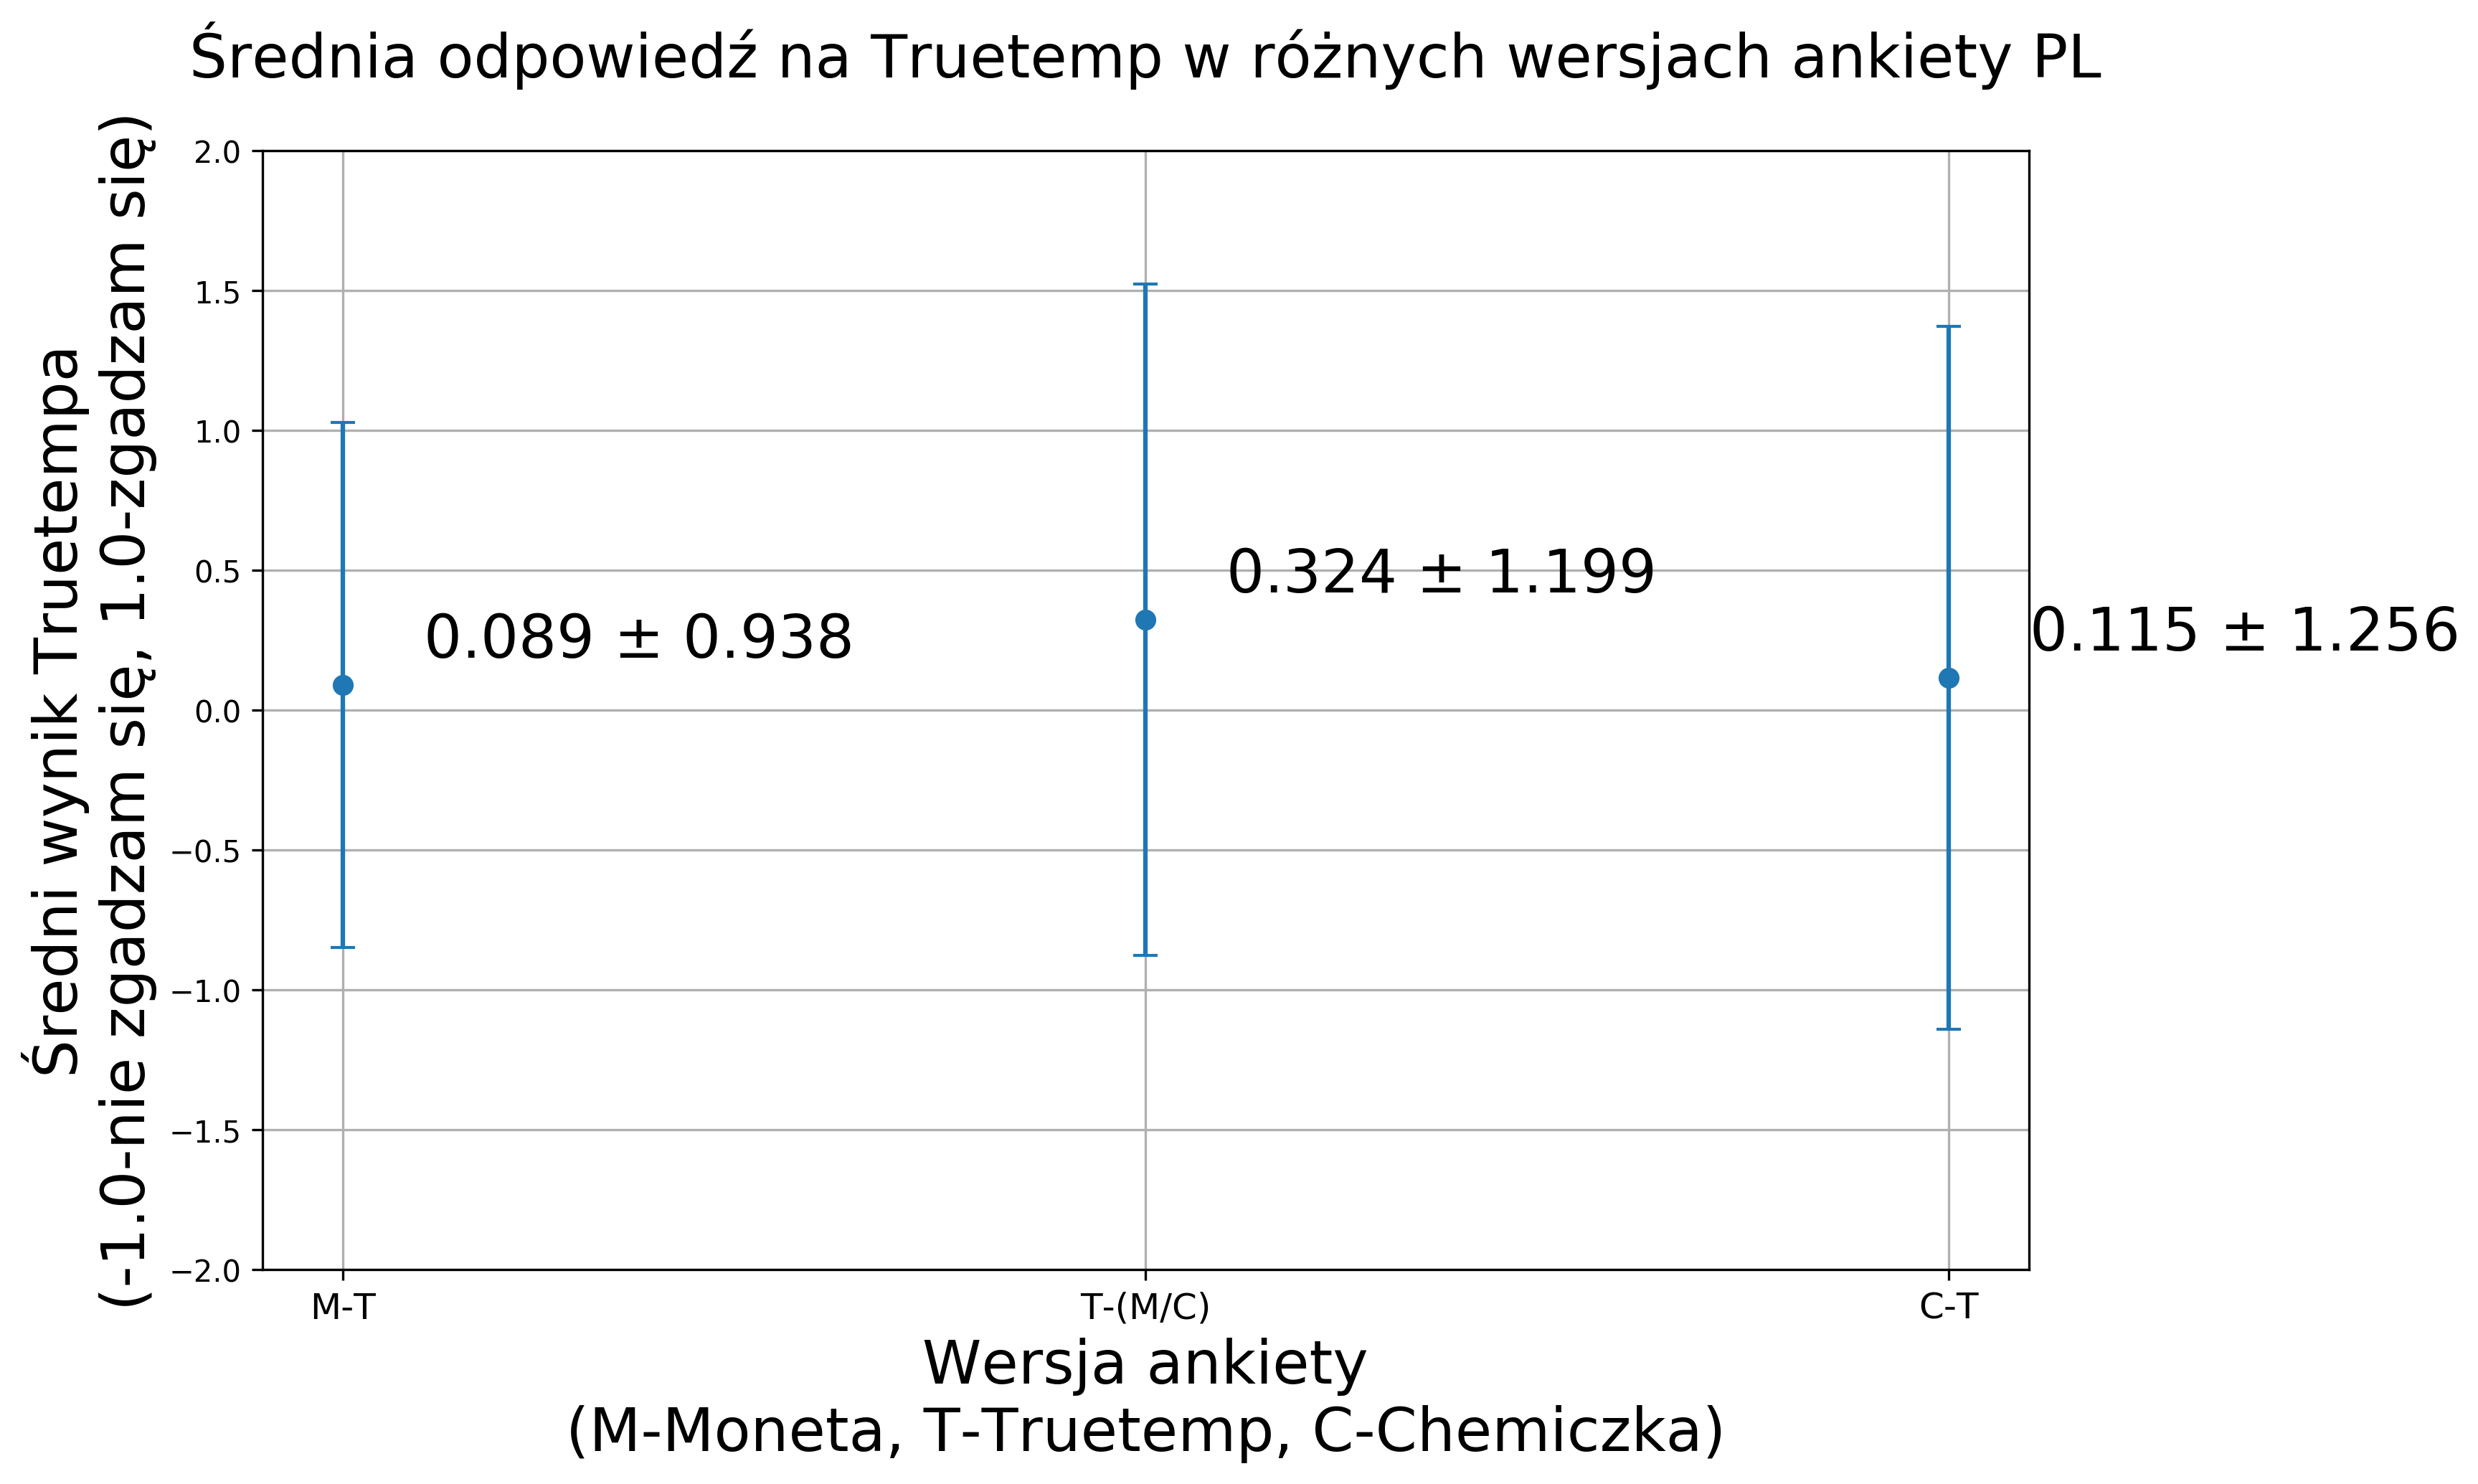

In [6]:
dfs = process(0)
truetemp_data = get_truetemp_data(dfs)
show_truetemp_answers_stats(truetemp_data)
perform_anova_variations(truetemp_data)
plot_truetemp_dependence_on_preceding_story(truetemp_data, 'mean_truetemp', language='pl', format='png')

special_data_request(truetemp_data)
special_data_request_2(dfs, 'pl')

Podsumowanie po grupach
Wszystkie oceny truetempa: 192

group                answers
-----------------  ---------
Coinflip-Truetemp         49
Truetemp-Coinflip         48
Truetemp-Chemist          46
Chemist-Truetemp          49 

Test dzielony po wszystkich grupach
Coinflip-Truetemp, Truetemp-Coinflip, Truetemp-Chemist, Chemist-Truetemp
F_onewayResult(statistic=0.41958822206237983, pvalue=0.7391543540655554) 

Test dzielony po kolejności truetempa i poprzedzającej historyjce
c-t, t-*, ch-t
F_onewayResult(statistic=0.21687209073103741, pvalue=0.8052329888491696) 

Test dzielony tylko po kolejności truetempa
*-t, t-*
F_onewayResult(statistic=0.4107461692942566, pvalue=0.5223632782076342)
Ttest_indResult(statistic=-0.6408948192131507, pvalue=0.5223632782076424) 

Test wpływu na truetempa
c-t, ch-t
F_onewayResult(statistic=0.02373887240356083, pvalue=0.8778746344882873)
Ttest_indResult(statistic=0.15407424315426904, pvalue=0.8778746344882733)
preceding      truetemp mean    truetemp std


/Users/derrkater/PycharmProjects/survey_analysis/survey_analysis/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Coinflip-Truetemp: 0.286 +/- 1.178
Truetemp-Coinflip: 0.500 +/- 1.258
Truetemp-Chemist: 0.261 +/- 1.188
Chemist-Truetemp: 0.245 +/- 1.407


group                -2    -1    0    1    2
-----------------  ----  ----  ---  ---  ---
Coinflip-Truetemp     5     9    7   23    5
Truetemp-Coinflip     2    12    8   12   14
Truetemp-Chemist      3    13    5   19    6
Chemist-Truetemp      4    17    6    7   15
females: 70, males: 122

Age: 36.792 +/- 12.614


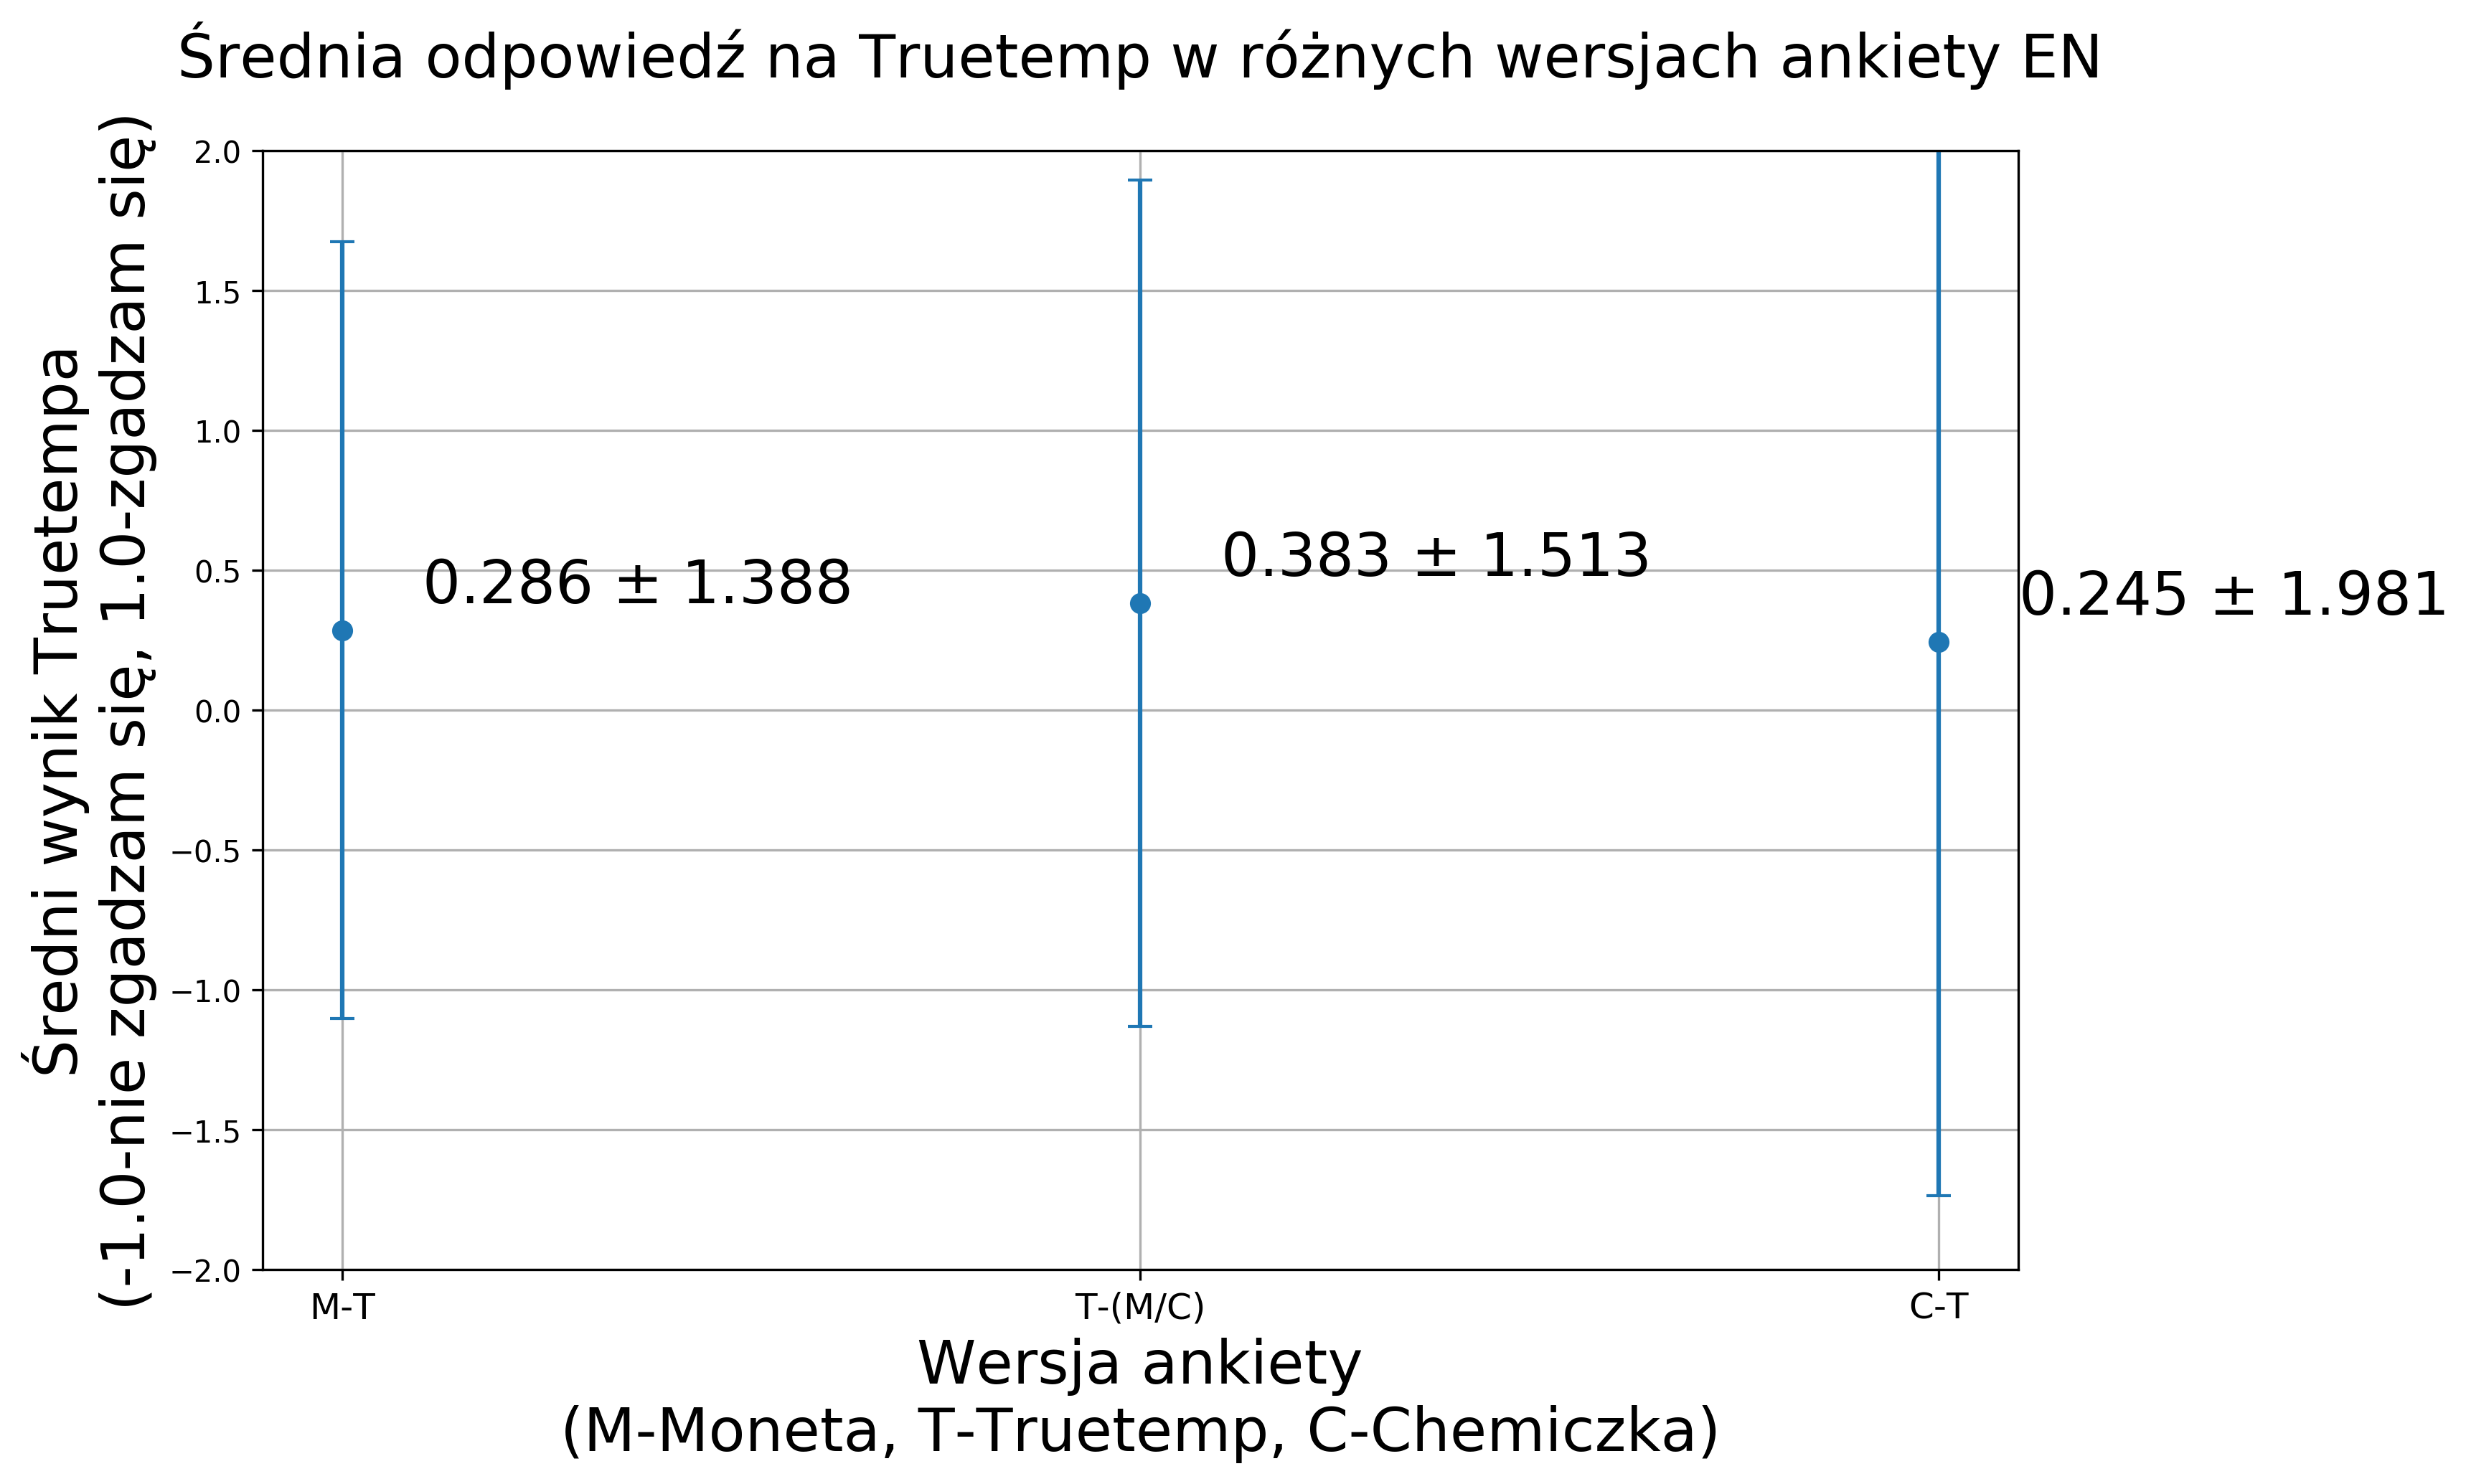

In [7]:
dfs = process(1)
truetemp_data = get_truetemp_data(dfs)
show_truetemp_answers_stats(truetemp_data)
perform_anova_variations(truetemp_data)
plot_truetemp_dependence_on_preceding_story(truetemp_data, 'mean_truetemp', language='en', format='png')

special_data_request(truetemp_data)
special_data_request_2(dfs, 'en')